# Table E4 
## Multivariate analysis with image-expression axes (IEAs) and COPD measurements 

In [1]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


# Loading data

In [2]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_IEA_all = pd.concat( [df_IEA_train, df_IEA_test] )

In [3]:
df = utility.load_data()

df_used = pd.merge(df, df_IEA_all, left_index = True, right_index = True)

/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
../../src/utility.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cov[df_cov == ""] = "nan"
/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# Linear regression with both IEAs and COPD measurements

In [4]:
independents = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

dependents = ['FEV1pp_utah_P2', 'FEV1_FVC_utah_P2', 'SGRQ_scoreTotal_P2', "MMRCDyspneaScor_P2", 'distwalked_P2',
           'delta_FEV1pp_P2P3', "delta_FEV1FVC_P2P3",
           ]

models_IEA = []
cov_dict_IEA = {iii:[] for iii in independents}

In [5]:
for ccc in dependents:
    X = df_used[independents]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx].astype(float)
    
    X = sm.add_constant(X.apply(stats.zscore))
    y = stats.zscore(y)
    
    
    M_OLS = sm.OLS(y, X).fit()

    models_IEA.append(M_OLS)

    
    v = M_OLS.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_IEA[col].append(eee + "\n" + CI1)

# Linear regression with COPD measurements only

In [6]:
independents = ["Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

dependents = ['FEV1pp_utah_P2', 'FEV1_FVC_utah_P2', 'SGRQ_scoreTotal_P2', "MMRCDyspneaScor_P2", 'distwalked_P2',
           'delta_FEV1pp_P2P3', "delta_FEV1FVC_P2P3",
           ]

models_base = []
cov_dict_base = {iii:[] for iii in independents}

In [7]:
for ccc in dependents:
    X = df_used[independents]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx].astype(float)
    
    X = sm.add_constant(X.apply(stats.zscore))
    y = stats.zscore(y)
    
    
    M_OLS = sm.OLS(y, X).fit()

    models_base.append(M_OLS)

    
    v = M_OLS.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_base[col].append(eee + "\n" + CI1)

# Computing p-values for likelihood ratio test

In [8]:
cols = ""

In [9]:

from scipy.stats.distributions import chi2


p_values = []

for iii in range(len(models_IEA)):
    model_null = models_base[iii]
    model_alt = models_IEA[iii]
    
    ll_null = model_null.llf
    ll_alt = model_alt.llf
    dg_null = model_null.df_model
    dg_alt = model_alt.df_model
    
    chi2_stat = -2 * (ll_null-ll_alt)
    p = chi2.sf(chi2_stat, dg_alt-dg_null)
    
    p_values.append( p )

p_values_str = []
for iii in p_values:
    if iii < .001:
        p_values_str.append("<.001")
    else:
        p_values_str.append("{:.3f}".format(iii))
    
p_values = np.array(p_values)[:, None]
p_values_str = np.array(p_values_str)[:, None]

# Table for p-values

In [10]:
rows = ["FEV$_1$ %predicted", "FEV$_1$ / FVC", "SGRQ Total Score", "MMRC Dyspnea Score", "6-Minute-Walk Distance", 
        "$\Delta$FEV$_1$ %predicted", "$\Delta$FEV$_1$/FVC"
       ]


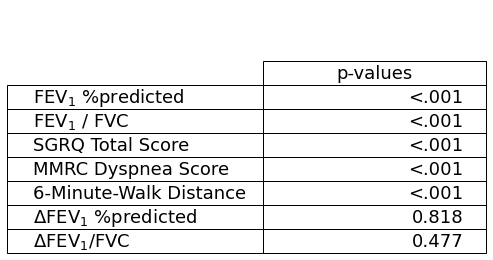

In [11]:
fig, ax = plt.subplots(figsize=(2,1))

the_table=plt.table(cellText = p_values_str, rowLabels = rows, 
                    colLabels = ["p-values"])

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

# Table for beta coeffcients ( COPD measurements )

In [12]:
independents = [
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

cov_label = [ 'Age',
 'Gender,\n%females', 'Race, \n%African-American',
 'Pack Years', 'Body Mass Index \n(BMI)',
 'Smoking Status', '%Emphysema \nat -950HU',
 'perc15',
 '%Gas Trapping',
 'Pi10',
 '%Airway Wall, \nSegmental']

In [13]:
table = np.array( [ [cov_dict_base[ccc][iii] for ccc in independents] for iii in range(len(models_base))  ] )

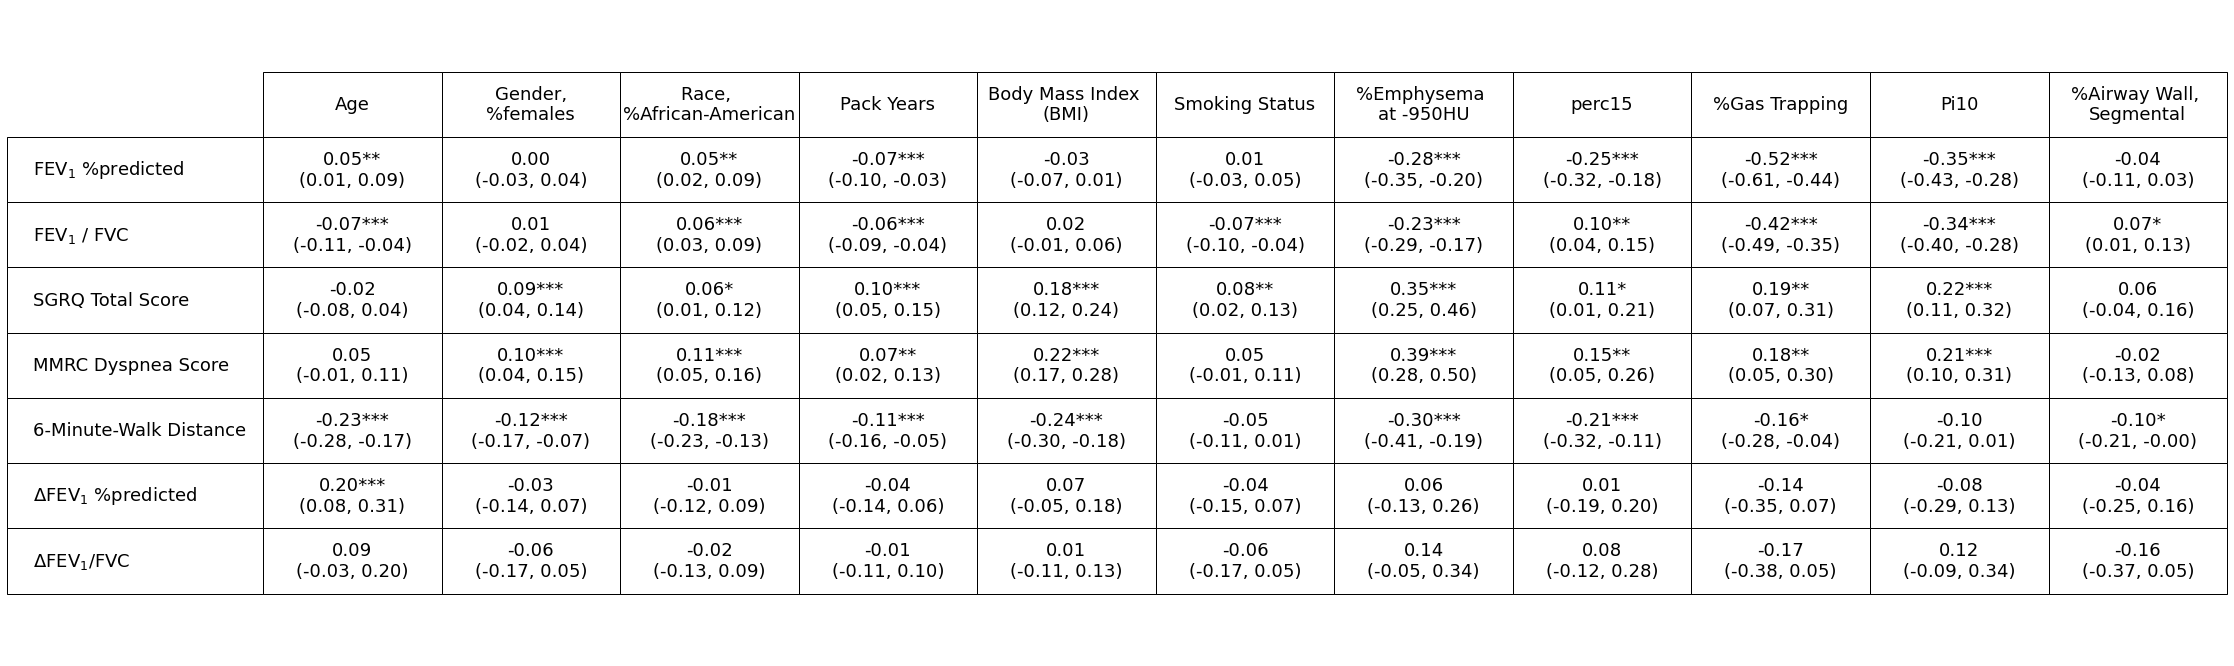

In [14]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    

# Table for beta coeffcients ( COPD measurements + IEAs )

In [15]:
independents = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

cov_label = [ 'IEA$_{emph}$', 'IEA$_{airway}$' ,'Age',
 'Gender,\n%females', 'Race, \n%African-American',
 'Pack Years', 'Body Mass Index \n(BMI)',
 'Smoking Status', '%Emphysema \nat -950HU',
 'perc15',
 '%Gas Trapping',
 'Pi10',
 '%Airway Wall, \nSegmental']

In [16]:
table = np.array( [ [cov_dict_IEA[ccc][iii] for ccc in independents] for iii in range(len(models_base))  ] )

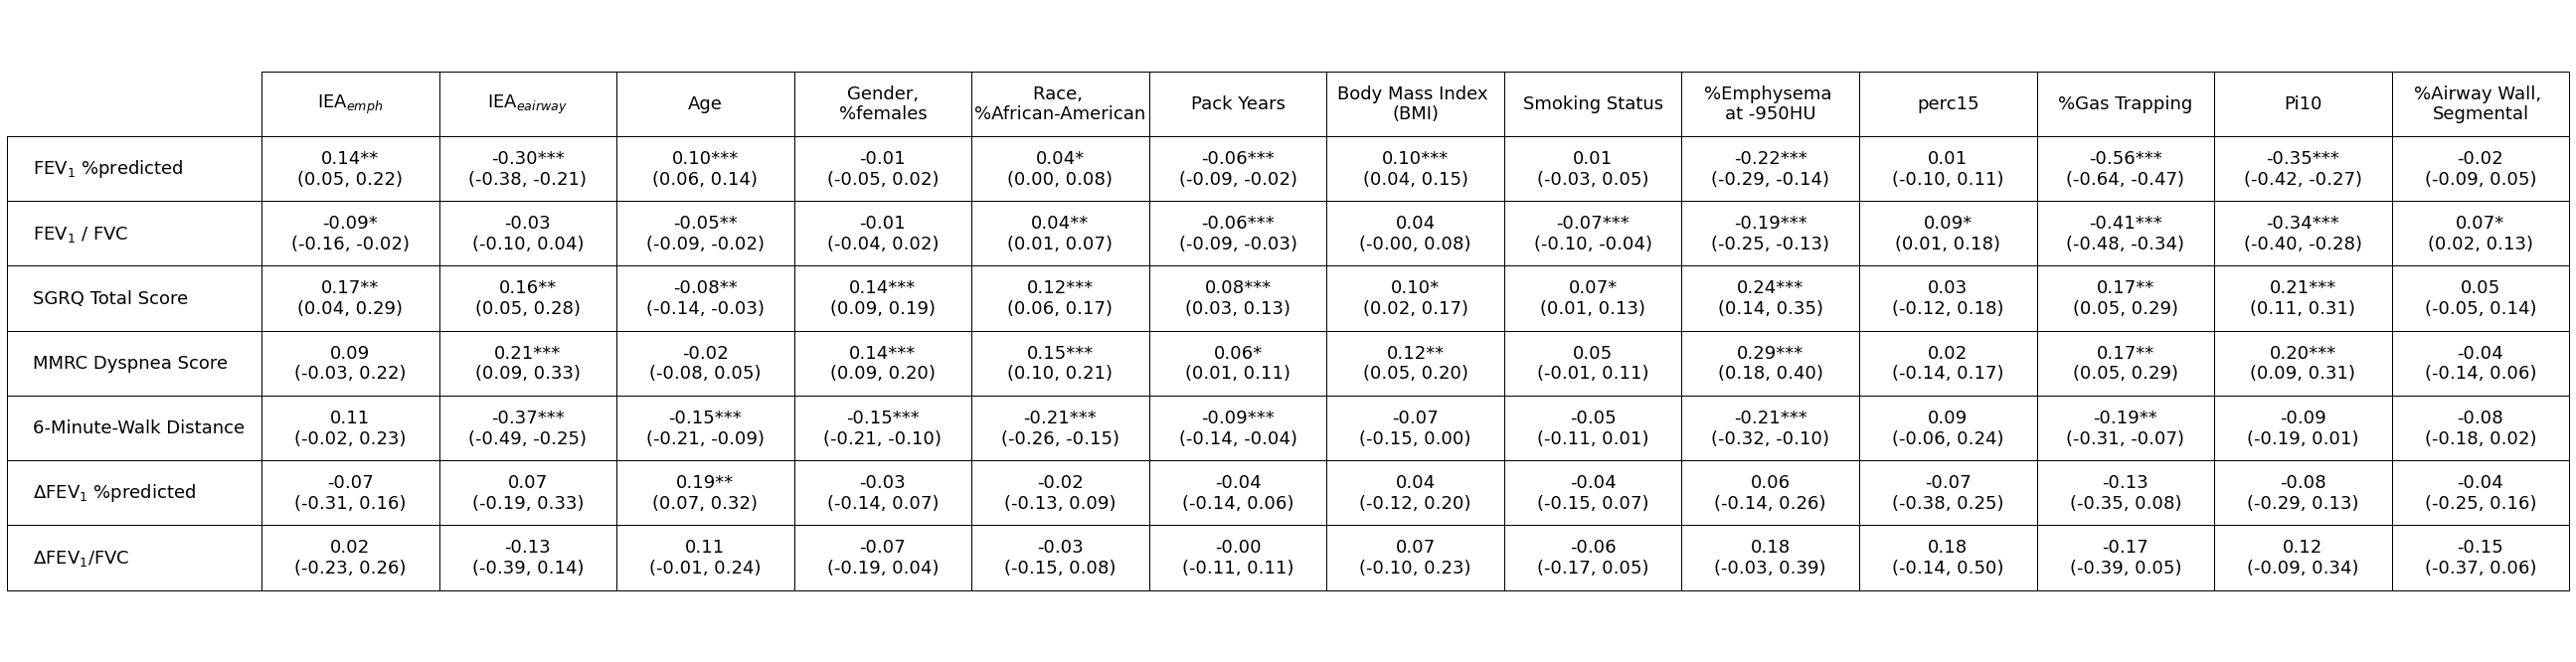

In [17]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    